In [59]:
%load_ext autoreload
%autoreload 2
import sys

# instead of creating a package using setup.py or building from a docker/singularity file,
# import the sister directory of src code to be called on in notebook.
# This keeps the notebook free from code to only hold visualizations and is easier to test
# It also helps keep the state of variables clean such that cells aren't run out of order with a mysterious state
sys.path.append("..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
import xarray as xr
import numpy as np
import pandas as pd
import datetime as dt
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [61]:
save_path = "/home/aevans/nwp_bias/src/machine_learning/data/profiler_images/"

In [62]:
radiometer_data_path = (
    "/home/aevans/nysm/archive/profiler/netcdf/proc-range/2024/04/20240411.nc"
)

In [63]:
df = xr.open_mfdataset(f"{radiometer_data_path}")

In [64]:
df

<xarray.Dataset>
Dimensions:                    (time: 144, station: 18, range: 173)
Coordinates:
  * time                       (time) datetime64[ns] 2024-04-11T00:05:00 ... ...
  * station                    (station) object 'PROF_ALB2' ... 'PROF_WEBS'
  * range                      (range) int64 0 25 50 75 ... 9250 9500 9750 10000
Data variables: (12/27)
    temperature                (station, time, range) float32 dask.array<chunksize=(18, 144, 173), meta=np.ndarray>
    temperature_qc             (station, time) float32 dask.array<chunksize=(18, 144), meta=np.ndarray>
    relative_humidity          (station, time, range) float32 dask.array<chunksize=(18, 144, 173), meta=np.ndarray>
    relative_humidity_qc       (station, time) float32 dask.array<chunksize=(18, 144), meta=np.ndarray>
    vapor_density              (station, time, range) float32 dask.array<chunksize=(18, 144, 173), meta=np.ndarray>
    vapor_density_qc           (station, time) float32 dask.array<chunksize=(18, 144), meta=np.ndarray>
    ...                         ...
    u                          (station, time, range) float32 dask.array<chunksize=(18, 144, 173), meta=np.ndarray>
    v                          (station, time, range) float32 dask.array<chunksize=(18, 144, 173), meta=np.ndarray>
    w                          (station, time, range) float32 dask.array<chunksize=(18, 144, 173), meta=np.ndarray>
    velocity                   (station, time, range) float32 dask.array<chunksize=(18, 144, 173), meta=np.ndarray>
    direction                  (station, time, range) float32 dask.array<chunksize=(18, 144, 173), meta=np.ndarray>
    dewpoint                   (station, time, range) float32 dask.array<chunksize=(18, 144, 173), meta=np.ndarray>
Attributes:
    source:       summary calculated from original native samples from lidar ...
    institution:  NYS Mesonet at the State University of New York at Albany
    last_update:  2024-04-12T00:51:14Z
    title:        summarized profiler network products
    featureType:  timeSeries
    comment:      All times are in UTC. Minimal QC has been applied. Use with...
    Conventions:  CF-1.8

In [65]:
df = df.to_dataframe()

In [66]:
df.reset_index(inplace=True)

In [67]:
# sites = df['station'].unique()
# for i in np.arange(2018,2026):
#     for s in sites:
#         os.mkdir(f'{save_path}/{i}/{s}')

In [68]:
df["temperature"] = df["temperature"] - 273.13
df["ir_temperature"] = df["ir_temperature"] - 273.13
df["dewpoint"] = df["dewpoint"] - 273.13
df["relative_humidity"] = df["relative_humidity"] / 100

In [69]:
for c in df.columns:
    print("column", c)
    # Count NaN values in the 'temperature' column
    nan_count = df[c].isna().sum()

    percent = (nan_count / 423504) * 100
    print("percent of column that is corrupted", percent)

column time
percent of column that is corrupted 0.0
column station
percent of column that is corrupted 0.0
column range
percent of column that is corrupted 0.0
column temperature
percent of column that is corrupted 17.647058823529413
column temperature_qc
percent of column that is corrupted 17.647058823529413
column relative_humidity
percent of column that is corrupted 17.647058823529413
column relative_humidity_qc
percent of column that is corrupted 17.647058823529413
column vapor_density
percent of column that is corrupted 17.647058823529413
column vapor_density_qc
percent of column that is corrupted 17.647058823529413
column liquid
percent of column that is corrupted 17.647058823529413
column liquid_qc
percent of column that is corrupted 17.647058823529413
column cloud_base
percent of column that is corrupted 17.647058823529413
column integrated_vapor
percent of column that is corrupted 17.647058823529413
column integrated_liquid
percent of column that is corrupted 17.64705882352941

In [70]:
# Drop columns with the suffix '_qc'
df = df.drop(columns=df.filter(like="_qc").columns)
df = df.drop(columns=df.filter(like="surface").columns)
drop_list = ["v", "w", "velocity", "direction", "u", "cnr", "rws"]
df = df.drop(columns=drop_list)
df = df[df["range"] <= 5000]
df.head()

,time,station,range,temperature,relative_humidity,vapor_density,liquid,cloud_base,integrated_vapor,integrated_liquid,ir_temperature,rain_flag,pressure_level,dewpoint
0,2024-04-11 00:05:00,PROF_ALB2,0,11.928314,0.936533,9.914166,0.001000,1.466667,2.365,0.601,5.384308,0.0,1003.185730,10.918976
1,2024-04-11 00:05:00,PROF_ALB2,25,12.878662,0.867122,9.668250,0.001000,1.466667,2.365,0.601,5.384308,0.0,1000.198975,10.591858
2,2024-04-11 00:05:00,PROF_ALB2,50,13.828979,0.797710,9.422334,0.001000,1.466667,2.365,0.601,5.384308,0.0,997.212280,10.255768
3,2024-04-11 00:05:00,PROF_ALB2,75,13.660065,0.794382,9.244167,0.009583,1.466667,2.365,0.601,5.384308,0.0,994.251404,9.961884
4,2024-04-11 00:05:00,PROF_ALB2,100,13.491150,0.791053,9.066001,0.018167,1.466667,2.365,0.601,5.384308,0.0,991.290527,9.663147


In [71]:
df = df[df["station"] == "PROF_ALBA"]
df.fillna(-999, inplace=True)
df = df.drop(columns="station")
df["time"] = pd.to_datetime(df["time"])

In [72]:
# Extract unique days
unique_days = df["time"].dt.date.unique()

In [73]:
unique_days

array([datetime.date(2024, 4, 11)], dtype=object)

In [74]:
# # Filter rows where the hour matches the query time's hour
# filtered_df = df[df['datetime'].dt.hour == query_time.hour]

In [75]:
df

,time,range,temperature,relative_humidity,vapor_density,liquid,cloud_base,integrated_vapor,integrated_liquid,ir_temperature,rain_flag,pressure_level,dewpoint
173,2024-04-11 00:05:00,0,11.765015,0.996100,10.43750,0.05250,0.900000,2.839500,0.547000,4.826660,0.0,1007.253967,11.685974
174,2024-04-11 00:05:00,25,12.121765,0.961057,10.14275,0.07700,0.900000,2.839500,0.547000,4.826660,0.0,1004.247192,11.272308
175,2024-04-11 00:05:00,50,12.478485,0.926015,9.84800,0.10150,0.900000,2.839500,0.547000,4.826660,0.0,1001.240417,10.847321
176,2024-04-11 00:05:00,75,12.146973,0.927613,9.64100,0.08825,0.900000,2.839500,0.547000,4.826660,0.0,998.251831,10.511169
177,2024-04-11 00:05:00,100,11.815491,0.929210,9.43400,0.07500,0.900000,2.839500,0.547000,4.826660,0.0,995.263245,10.169006
...,...,...,...,...,...,...,...,...,...,...,...,...,...
445591,2024-04-11 23:55:00,4800,-10.396820,0.670435,1.59440,0.00100,0.466667,3.345333,1.288667,11.589996,1.0,550.210327,-14.803894
445592,2024-04-11 23:55:00,4850,-10.691956,0.650821,1.51380,0.00100,0.466667,3.345333,1.288667,11.589996,1.0,546.669617,-15.442169
445593,2024-04-11 23:55:00,4900,-10.987091,0.631206,1.43320,0.00100,0.466667,3.345333,1.288667,11.589996,1.0,543.128906,-16.110718
445594,2024-04-11 23:55:00,4950,-11.282227,0.611591,1.35260,0.00100,0.466667,3.345333,1.288667,11.589996,1.0,539.588135,-16.812805


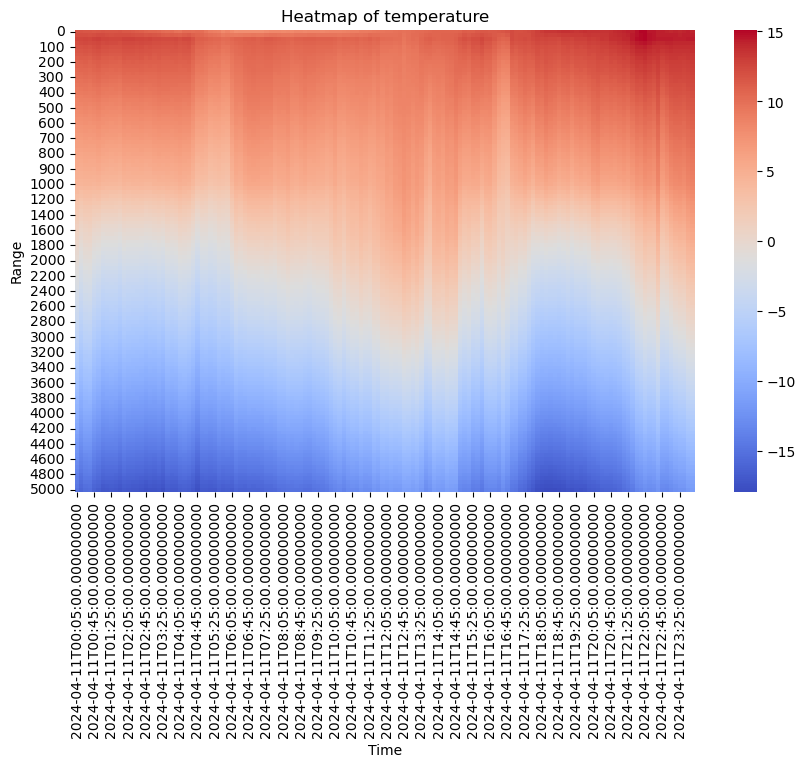

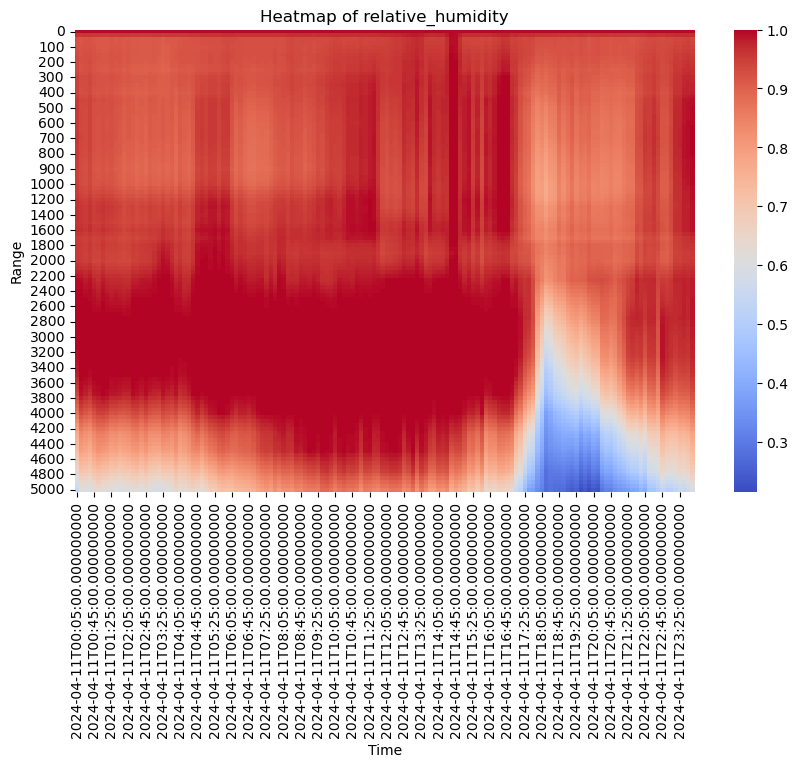

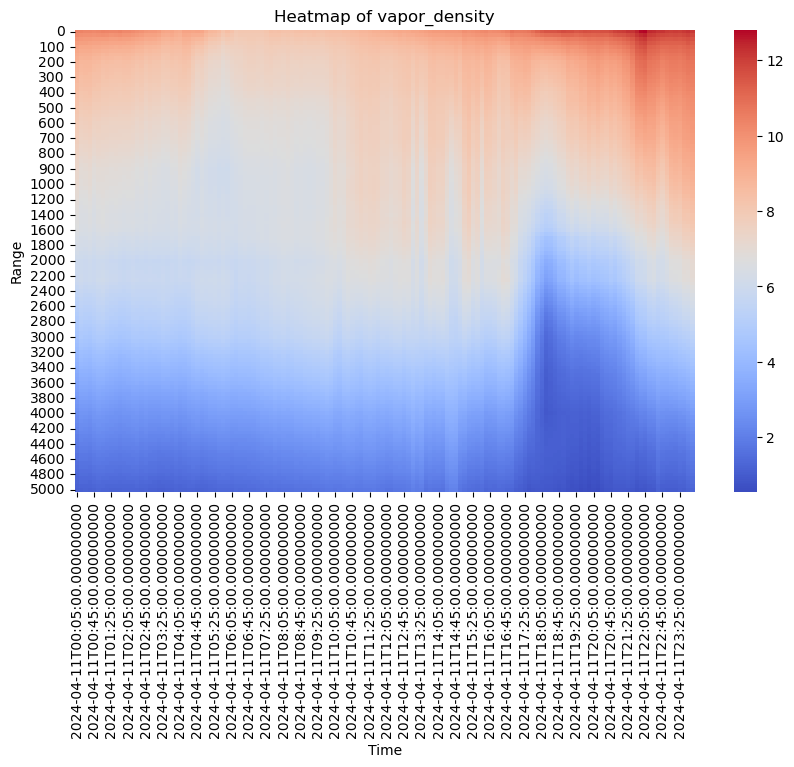

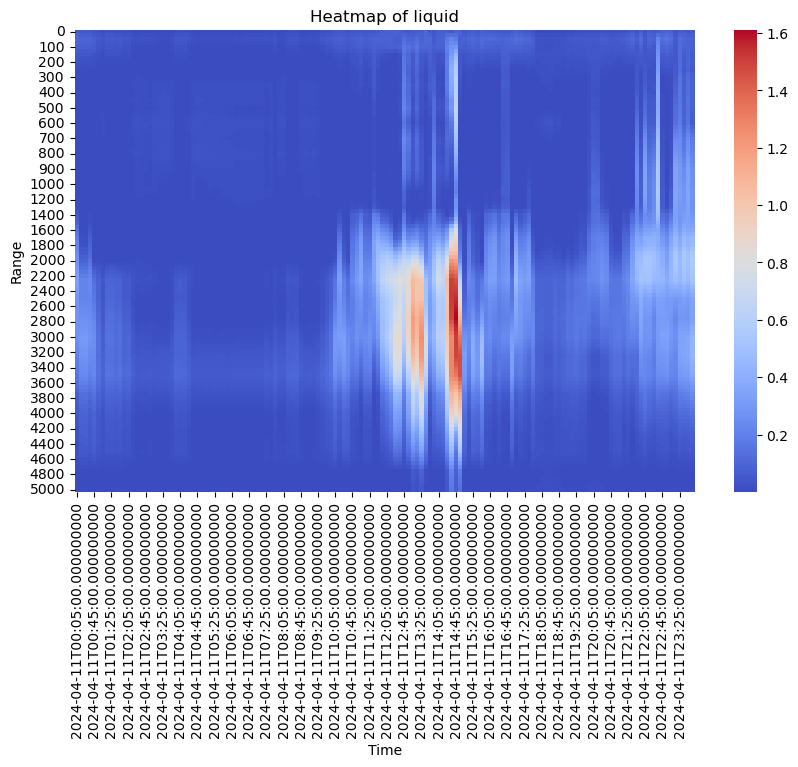

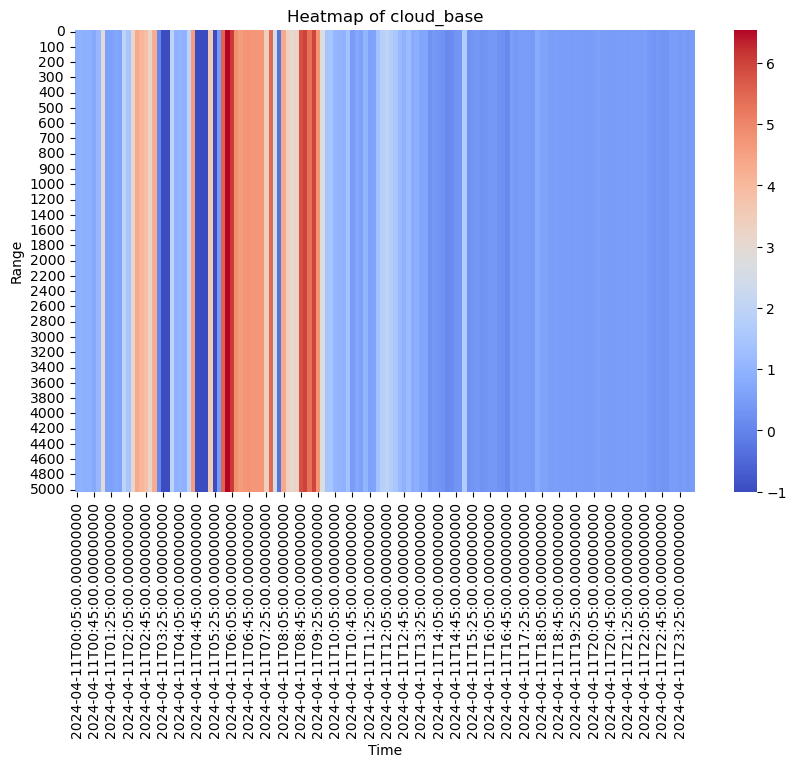

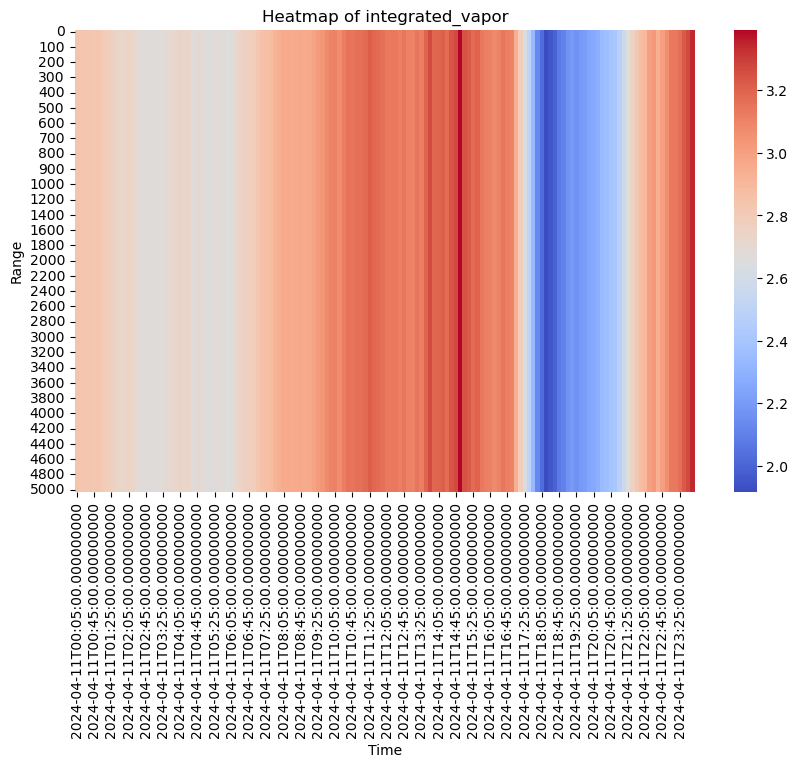

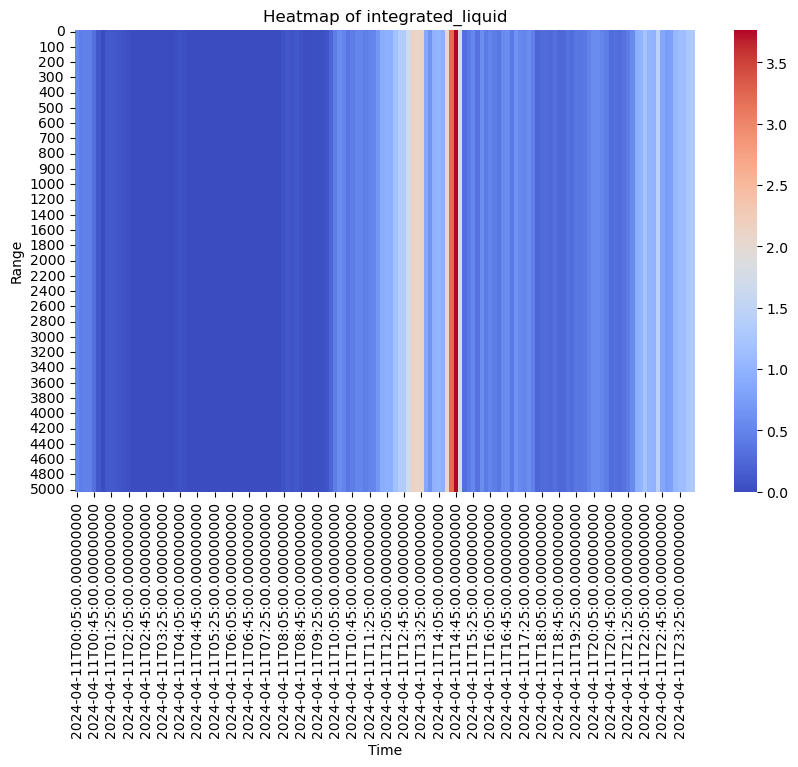

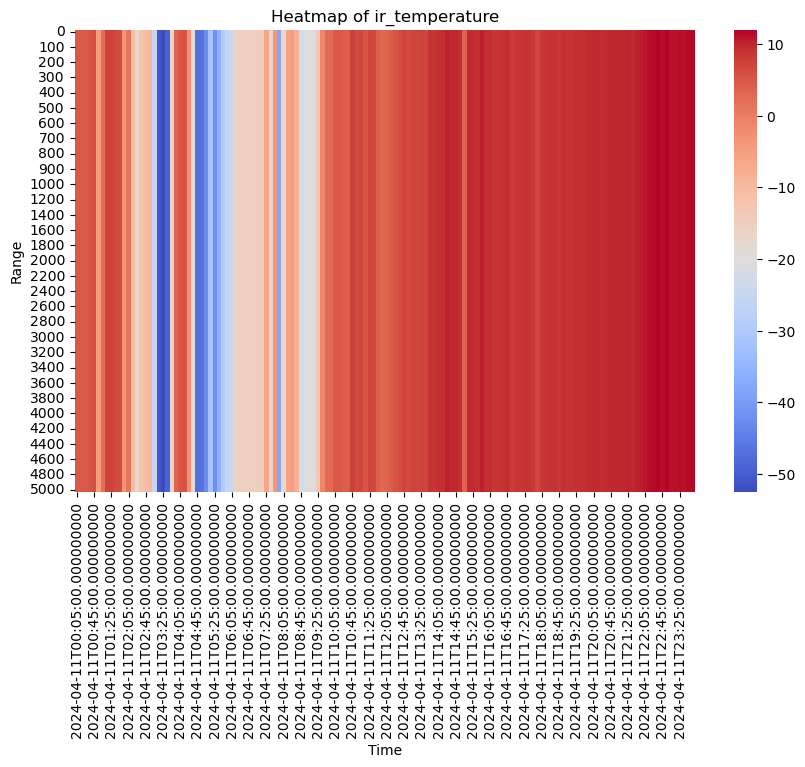

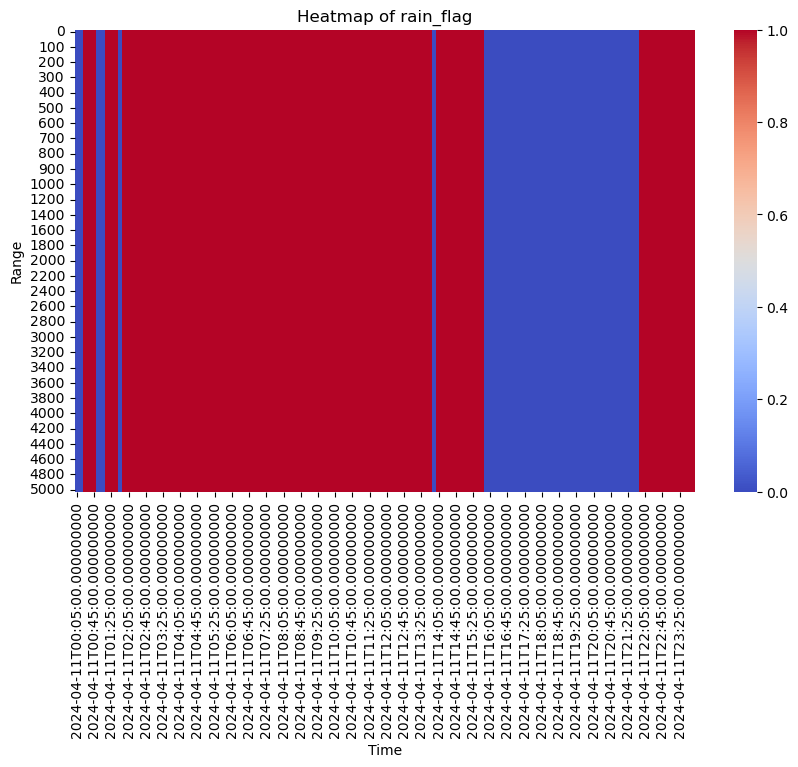

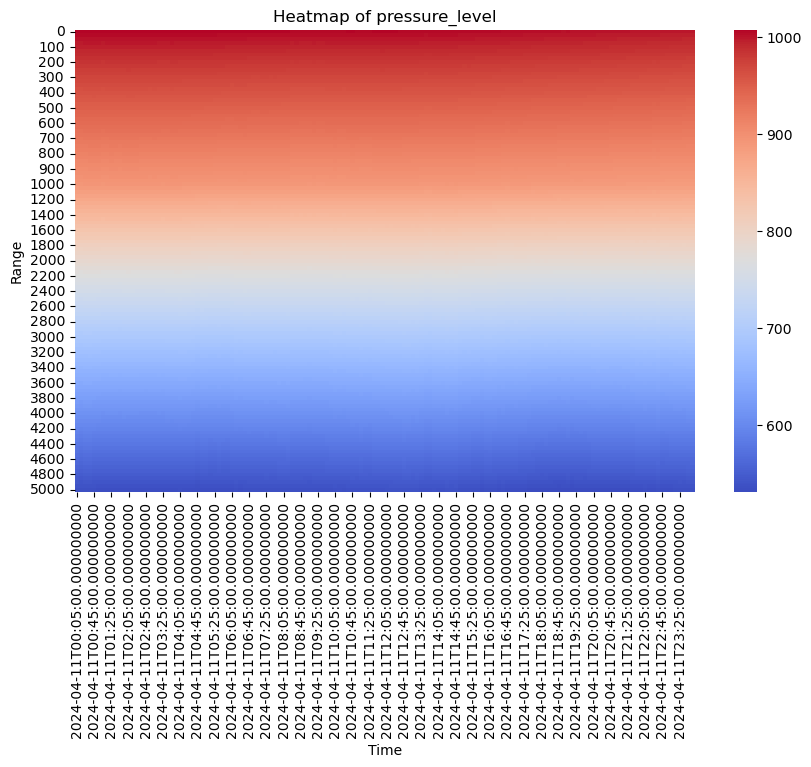

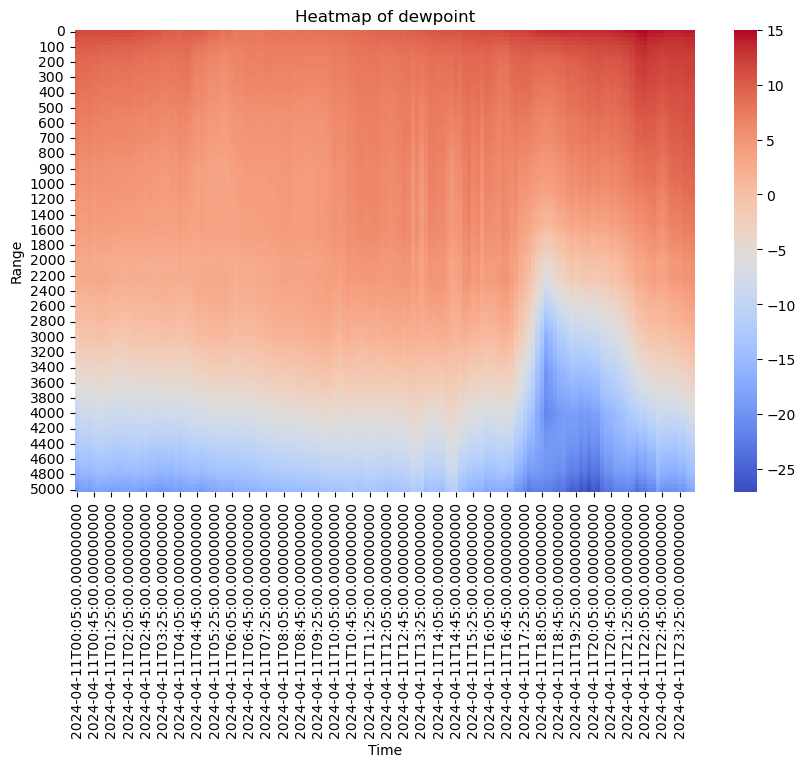

In [76]:
skip_list = ["time", "range"]
for c in df.columns:
    if c in skip_list:
        continue
    else:
        var_pivot = df.pivot(index="range", columns="time", values=c)
        var_array = var_pivot.to_numpy()
        try:
            stacked_array = np.vstack((stacked_array, var_array))
        except:
            stacked_array = var_array
        plt.figure(figsize=(10, 6))
        sns.heatmap(var_pivot, cmap="coolwarm", cbar=True)
        plt.title(f"Heatmap of {c}")
        plt.xlabel("Time")
        plt.ylabel("Range")
        plt.show()

In [77]:
stacked_array.shape

(4114, 144)

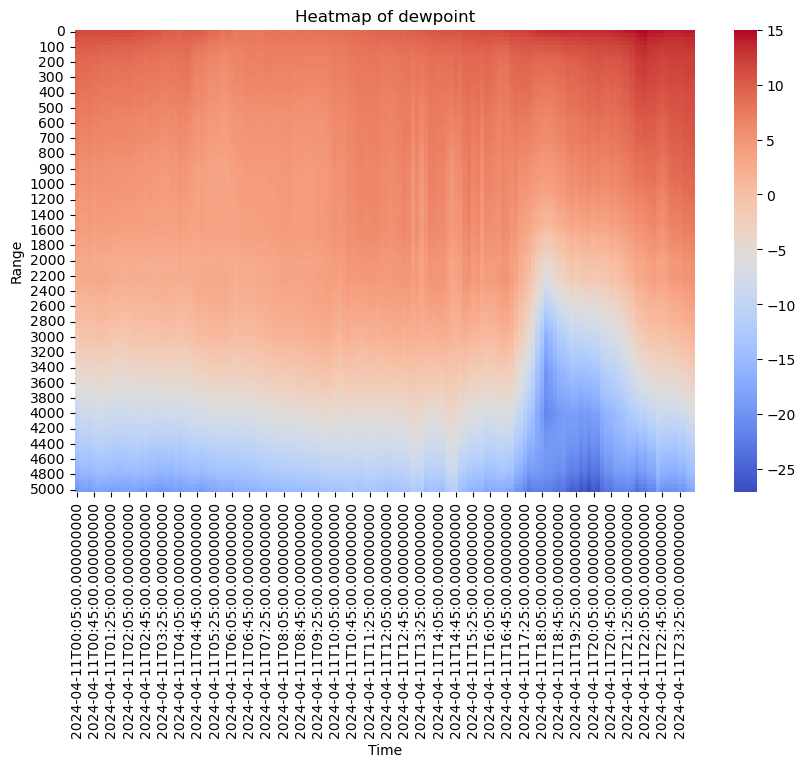

In [78]:
plt.figure(figsize=(10, 6))
sns.heatmap(var_pivot, cmap="coolwarm", cbar=True)
plt.title(f"Heatmap of {c}")
plt.xlabel("Time")
plt.ylabel("Range")
plt.show()